In [1]:
import sys
import numpy as np
import os
from os.path import abspath

import matplotlib.pyplot as plt
%matplotlib inline
import subtle.subtle_io as suio

# import subtle.subtle_preprocess as sup
import subtle.subtle_plot as suplot
import nibabel as nib
import nipype
from nipype.interfaces import fsl
import nipype.interfaces.io

from niwidgets import NiftiWidget
# NiftiWidget(_x0).nifti_plotter()

from IPython.display import Image
print(fsl.Info().version())


/home/jon/anaconda/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


6.0.0


In [2]:
working_dir = '/raid/jon/data_full_stanford/data/Patient_0545'

In [3]:
nib_files = []
for filename in os.listdir(working_dir):
    if ".nii" in filename.lower():
        nib_files.append(os.path.join(working_dir,filename))
order = np.argsort([int(os.path.basename(l).split('_')[0]) for l in nib_files])
nib_files = list(np.array(nib_files)[order])
print(nib_files)

['/raid/jon/data_full_stanford/data/Patient_0545/7_ax_bravo_pre.nii.gz', '/raid/jon/data_full_stanford/data/Patient_0545/10_ax_bravo_c_pre_load_10.nii.gz', '/raid/jon/data_full_stanford/data/Patient_0545/14_ax_bravoc.nii.gz']


In [4]:
## brain extraction
frac = .5
robust = True
reduce_bias = False

bet_zero_node = nipype.Node(fsl.BET(frac=frac, reduce_bias=reduce_bias), name='bet_zero')
bet_low_node = nipype.Node(fsl.BET(frac=frac, reduce_bias=reduce_bias), name='bet_low')
bet_full_node = nipype.Node(fsl.BET(frac=frac, reduce_bias=reduce_bias), name='bet_full')

In [5]:
## coregistration on brain extraction
cost = 'corratio'
dof = 6
searchr_x = [-20, 20]
searchr_y = [-20, 20]
searchr_z = [-20, 20]
bins = 256
interp = 'trilinear'

coreg_low_node = nipype.Node(fsl.FLIRT(cost=cost, dof=dof, interp=interp, bins=bins, searchr_x=searchr_x, searchr_y=searchr_y, searchr_z=searchr_z),
                             name='coreg_low')
coreg_full_node = nipype.Node(fsl.FLIRT(cost=cost, dof=dof, interp=interp, bins=bins, searchr_x=searchr_x, searchr_y=searchr_y, searchr_z=searchr_z),
                             name='coreg_full')


In [6]:
from nipype.interfaces.base import BaseInterface, \
    BaseInterfaceInputSpec, traits, File, TraitedSpec
from nipype.utils.filemanip import split_filename

import nibabel as nb
import numpy as np
import os

class SimpleThresholdInputSpec(BaseInterfaceInputSpec):
    volume = File(exists=True, desc='volume to be thresholded', mandatory=True)
    threshold = traits.Float(desc='everything below this value will be set to zero',
                             mandatory=True)


class SimpleThresholdOutputSpec(TraitedSpec):
    thresholded_volume = File(exists=True, desc="thresholded volume")


class SimpleThreshold(BaseInterface):
    input_spec = SimpleThresholdInputSpec
    output_spec = SimpleThresholdOutputSpec

    def _run_interface(self, runtime):
        fname = self.inputs.volume
        img = nb.load(fname)
        data = np.array(img.get_data())

        active_map = data > self.inputs.threshold

        thresholded_map = np.zeros(data.shape)
        thresholded_map[active_map] = data[active_map]

        new_img = nb.Nifti1Image(thresholded_map, img.affine, img.header)
        _, base, _ = split_filename(fname)
        nb.save(new_img, base + '_thresholded.nii.gz')

        return runtime

    def _list_outputs(self):
        outputs = self._outputs().get()
        fname = self.inputs.volume
        _, base, _ = split_filename(fname)
        outputs["thresholded_volume"] = os.path.abspath(base + '_thresholded.nii.gz')
        return outputs

In [7]:
from nipype.interfaces.base import BaseInterface, \
    BaseInterfaceInputSpec, traits, File, TraitedSpec
from nipype.utils.filemanip import split_filename

import nibabel as nb
import numpy as np
import os

class MaskCombineInputSpec(BaseInterfaceInputSpec):
    in0 = File(exists=True, desc='input 0', mandatory=True)
    in1 = File(exists=True, desc='input 1', mandatory=True)
    in2 = File(exists=True, desc='input 2', mandatory=True)



class MaskCombineOutputSpec(TraitedSpec):
    out = File(exists=True, desc="mask")


class MaskCombine(BaseInterface):
    input_spec = MaskCombineInputSpec
    output_spec = MaskCombineOutputSpec

    def _run_interface(self, runtime):
        f0 = self.inputs.in0
        f1 = self.inputs.in1
        f2 = self.inputs.in2
        
        x0 = nb.load(f0)
        x1 = nb.load(f1)
        x2 = nb.load(f2)
        
        mask = ((x0.get_fdata()>0) & (x1.get_fdata()>0) & (x2.get_fdata()>0))

        out = nb.Nifti1Image(mask, x0.affine, x0.header)
        _, base, _ = split_filename(f0)
        nb.save(out, base + '_combined_mask.nii.gz')

        return runtime

    def _list_outputs(self):
        outputs = self._outputs().get()
        fname = self.inputs.in0
        _, base, _ = split_filename(fname)
        outputs["out"] = os.path.abspath(base + '_combined_mask.nii.gz')
        return outputs

In [8]:
from nipype.interfaces.base import BaseInterface, \
    BaseInterfaceInputSpec, traits, File, TraitedSpec
from nipype.utils.filemanip import split_filename

import nibabel as nb
import numpy as np
import os

class ApplyMaskInputSpec(BaseInterfaceInputSpec):
    input_file = File(exists=True, desc='input', mandatory=True)
    mask = File(exists=True, desc='mask', mandatory=True)



class ApplyMaskOutputSpec(TraitedSpec):
    out = File(exists=True, desc="masked image")


class ApplyMask(BaseInterface):
    input_spec = ApplyMaskInputSpec
    output_spec = ApplyMaskOutputSpec

    def _run_interface(self, runtime):
        f0 = self.inputs.input_file
        fm = self.inputs.mask
        
        x0 = nb.load(f0)
        xm = nb.load(fm)
        
        x_out = x0.get_fdata() * xm.get_fdata()
        
        out = nb.Nifti1Image(x_out, x0.affine, x0.header)
        _, base, _ = split_filename(f0)
        nb.save(out, base + '_masked.nii.gz')

        return runtime

    def _list_outputs(self):
        outputs = self._outputs().get()
        fname = self.inputs.input_file
        _, base, _ = split_filename(fname)
        outputs["out"] = os.path.abspath(base + '_masked.nii.gz')
        return outputs

In [9]:
mask_node = nipype.Node(MaskCombine(), name='mask_combine')
masked_zero_node = nipype.Node(ApplyMask(), name='masked_zero')
masked_low_node = nipype.Node(ApplyMask(), name='masked_low')
masked_full_node = nipype.Node(ApplyMask(), name='masked_full')

190917-12:34:20,878 nipype.workflow INFO:
	 Generated workflow graph: /raid/jon/data_full_stanford/data/Patient_0545/registration/graph.png (graph2use=flat, simple_form=True).


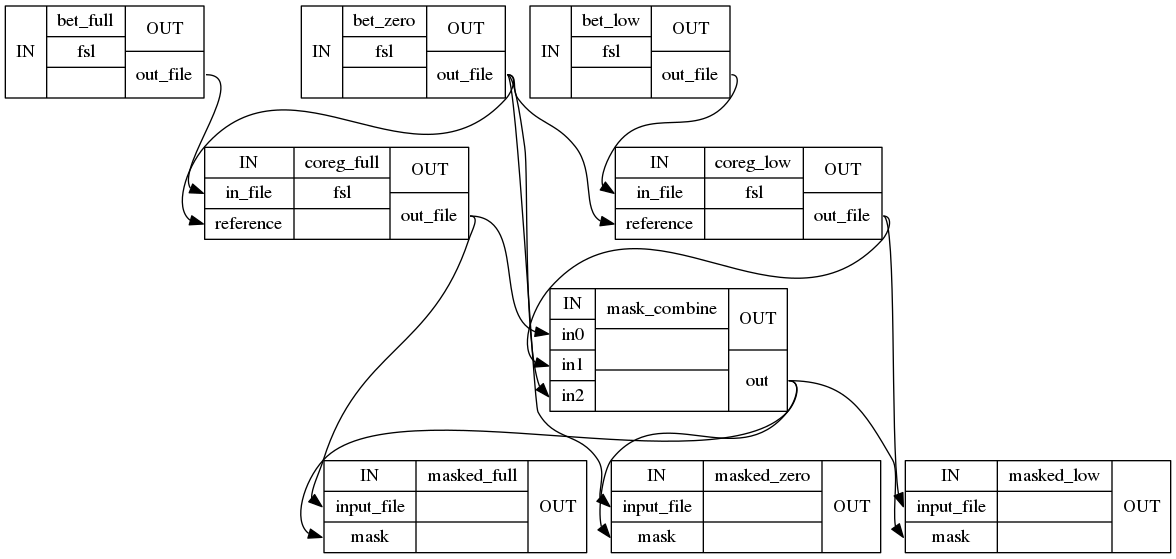

In [10]:
wf = nipype.Workflow(name='registration', base_dir=working_dir)
wf.connect([
    (bet_zero_node, coreg_low_node, [('out_file', 'reference')]), 
    (bet_low_node, coreg_low_node, [('out_file', 'in_file')]), 
    (bet_zero_node, coreg_full_node, [('out_file', 'reference')]), 
    (bet_full_node, coreg_full_node, [('out_file', 'in_file')]), 
#     (bet_zero_node, combine_masks_node, [('out_file', 'x0')]), 
#     (coreg_low_node, combine_masks_node, [('out_file', 'x1')]), 
#     (coreg_full_node, combine_masks_node, [('out_file', 'x2')]), 
    (coreg_full_node, mask_node, [('out_file', 'in0')]), 
    (coreg_low_node, mask_node, [('out_file', 'in1')]), 
    (bet_zero_node, mask_node, [('out_file', 'in2')]), 
    (mask_node, masked_zero_node, [('out', 'mask')]), 
    (mask_node, masked_low_node, [('out', 'mask')]), 
    (mask_node, masked_full_node, [('out', 'mask')]), 
    (bet_zero_node, masked_zero_node, [('out_file', 'input_file')]), 
    (coreg_low_node, masked_low_node, [('out_file', 'input_file')]), 
    (coreg_full_node, masked_full_node, [('out_file', 'input_file')]), 

           ])

# wf.write_graph('workflow_graph.dot')
# Image(filename='{working_dir}/registration/workflow_graph.png'.format(working_dir=working_dir))

wf.write_graph(graph2use='flat')
Image(filename='{working_dir}/registration/graph_detailed.png'.format(working_dir=working_dir))

In [11]:
bet_zero_node.inputs.in_file = nib_files[0]
bet_low_node.inputs.in_file = nib_files[1]
bet_full_node.inputs.in_file = nib_files[2]

# wf.run()
wf.run(plugin='MultiProc', plugin_args={'n_procs' : 8})

190917-12:34:20,912 nipype.workflow INFO:
	 Workflow registration settings: ['check', 'execution', 'logging', 'monitoring']
190917-12:34:20,920 nipype.workflow INFO:
	 Running in parallel.
190917-12:34:20,926 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 226.65/226.65, Free processors: 8/8.
190917-12:34:20,985 nipype.workflow INFO:
	 [Job 0] Cached (registration.bet_low).
190917-12:34:20,988 nipype.workflow INFO:
	 [Job 1] Cached (registration.bet_zero).
190917-12:34:20,990 nipype.workflow INFO:
	 [Job 3] Cached (registration.bet_full).
190917-12:34:22,928 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 226.65/226.65, Free processors: 8/8.
190917-12:34:23,10 nipype.workflow INFO:
	 [Job 2] Cached (registration.coreg_low).
190917-12:34:23,14 nipype.workflow INFO:
	 [Job 4] Cached (registration.coreg_full).
190917-12:34:24,930 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free mem

In [12]:
print(working_dir)
!tree /raid/jon/data_full_stanford/data/Patient_0545 -I '*js|*json|*html|*pklz|_report'


/raid/jon/data_full_stanford/data/Patient_0545
/raid/jon/data_full_stanford/data/Patient_0545
├── 10_ax_bravo_c_pre_load_10.nii.gz
├── 14_ax_bravoc.nii.gz
├── 7_ax_bravo_pre.nii.gz
└── registration
    ├── bet_full
    │   ├── 14_ax_bravoc_brain.nii.gz
    │   └── command.txt
    ├── bet_low
    │   ├── 10_ax_bravo_c_pre_load_10_brain.nii.gz
    │   └── command.txt
    ├── bet_zero
    │   ├── 7_ax_bravo_pre_brain.nii.gz
    │   └── command.txt
    ├── coreg_full
    │   ├── 14_ax_bravoc_brain_flirt.nii.gz
    │   └── command.txt
    ├── coreg_low
    │   ├── 10_ax_bravo_c_pre_load_10_brain_flirt.nii.gz
    │   └── command.txt
    ├── graph_detailed.dot
    ├── graph_detailed.png
    ├── graph.dot
    ├── graph.png
    ├── mask_combine
    │   └── 14_ax_bravoc_brain_flirt_combined_mask.nii.gz
    ├── masked_full
    │   └── 14_ax_bravoc_brain_flirt_masked.nii.gz
    ├── masked_low
    │   └── 10_ax_bravo_c_pre_load_10_brain_flirt_masked.nii.gz
    ├── masked_zero
    │   └── 7_ax_bravo

(512, 512, 352)


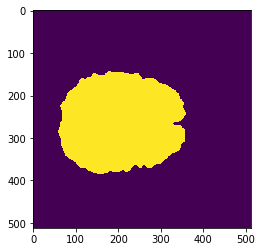

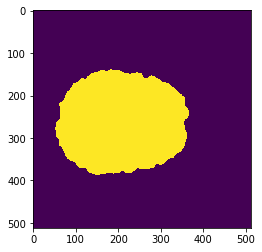

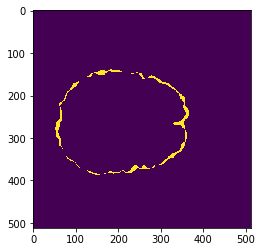

In [13]:
idx = 200
_tmp = nib.load('{}/registration/masked_low/10_ax_bravo_c_pre_load_10_brain_flirt_masked.nii.gz'.format(working_dir))
_tmp2 = nib.load('{}/registration/coreg_low/10_ax_bravo_c_pre_load_10_brain_flirt.nii.gz'.format(working_dir))
tmp2 = _tmp2.get_fdata()
tmp = _tmp.get_fdata()
print(tmp.shape)
plt.imshow(tmp[...,idx]>0)
plt.figure()
plt.imshow(tmp2[...,idx]>0)
plt.figure()
plt.imshow(((tmp>0)!=(tmp2>0))[...,idx])


In [14]:
_x0 = nib.load('{}/registration/masked_zero/7_ax_bravo_pre_brain_masked.nii.gz'.format(working_dir))
_x1 = nib.load('{}/registration/masked_low/10_ax_bravo_c_pre_load_10_brain_flirt_masked.nii.gz'.format(working_dir))
_x2 = nib.load('{}/registration/masked_full/14_ax_bravoc_brain_flirt_masked.nii.gz'.format(working_dir))
_x3 = nib.load('{}/registration/bet_full/14_ax_bravoc_brain.nii.gz'.format(working_dir))

x0, x1, x2, x3 = [__x.get_fdata() for __x in (_x0, _x1, _x2, _x3)]


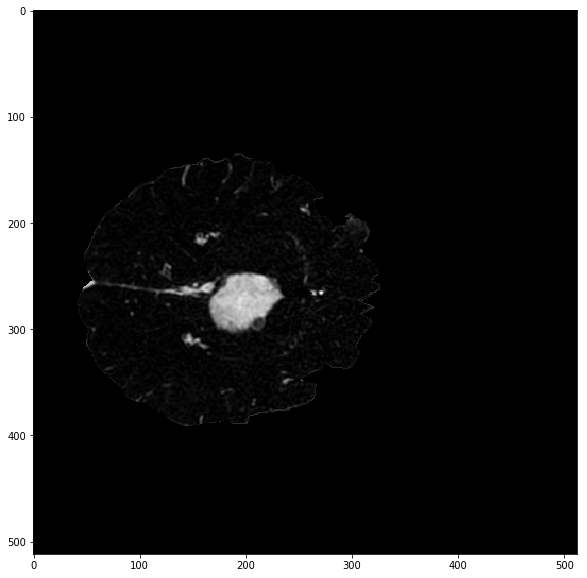

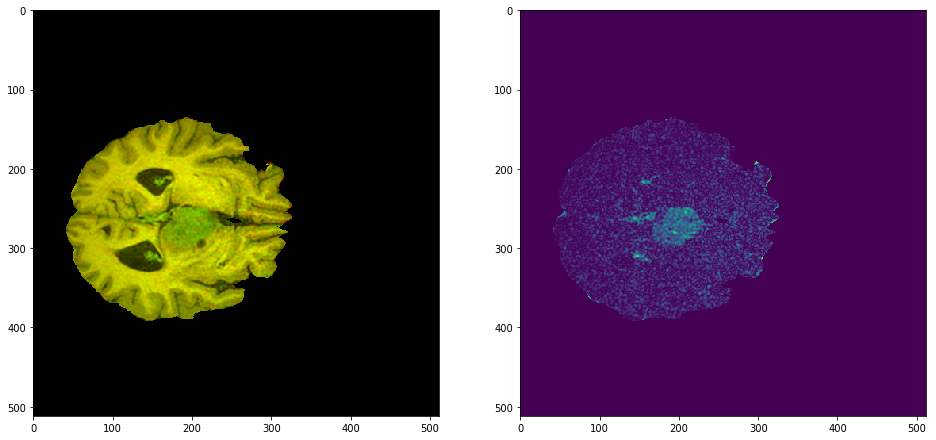

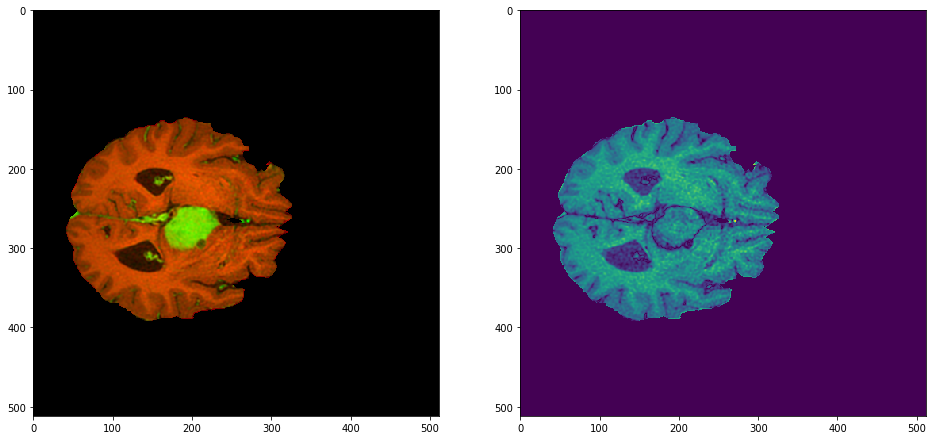

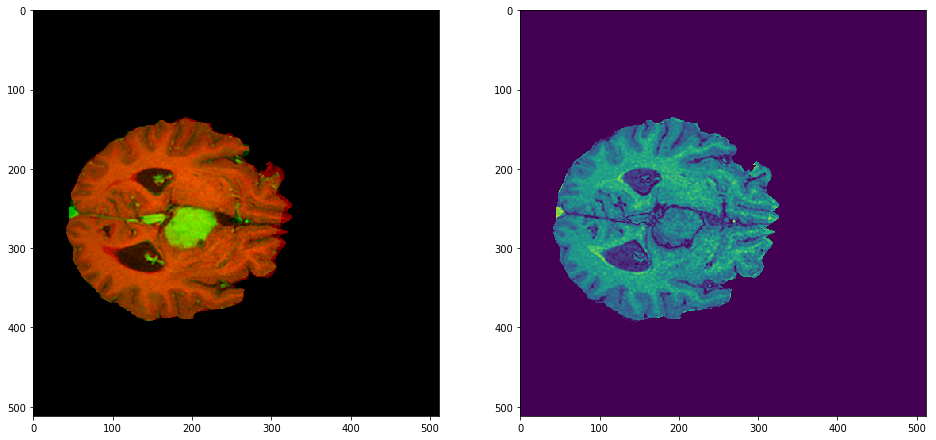

In [15]:
idx = 150

plt.figure(figsize=(16,10))
plt.imshow(abs(x2[...,idx] - x0[...,idx]), cmap='gray')

plt.figure(figsize=(16,10))
suplot.imshowreg(x0[...,idx], x1[...,idx])

plt.figure(figsize=(16,10))
suplot.imshowreg(x0[...,idx], x2[...,idx])

plt.figure(figsize=(16,10))
suplot.imshowreg(x0[...,idx], x3[..., idx])


## test kmeans to make enhancement mask 

In [16]:
from sklearn.cluster import KMeans

In [17]:
n = 6
idx_kmeans = np.arange(idx-20, idx+20)
X = np.stack((x0[...,idx_kmeans].ravel(), x1[...,idx_kmeans].ravel(), x2[...,idx_kmeans].ravel())).T
Xn = np.linalg.norm(X, axis=1)
print(X.shape)
X2 = X[Xn > 0.05*np.max(Xn)]
print(X2.shape)
kmeans = KMeans(n_clusters=n, random_state=723, n_jobs=10)
kmeans.fit(X2)

(10485760, 3)
(2117032, 3)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=10, precompute_distances='auto',
    random_state=723, tol=0.0001, verbose=0)

In [18]:
Y = kmeans.predict(X).reshape((x0[...,idx_kmeans].shape)).squeeze()
print(Y.shape)

(512, 512, 40)


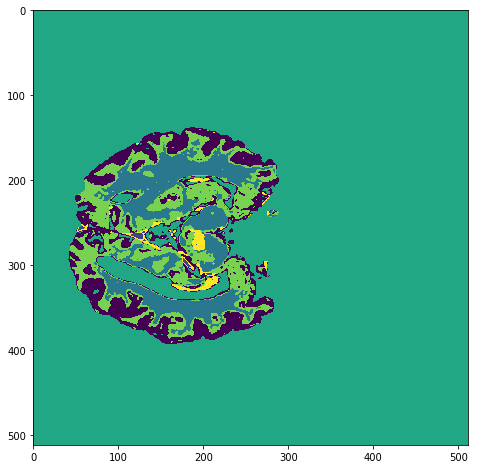

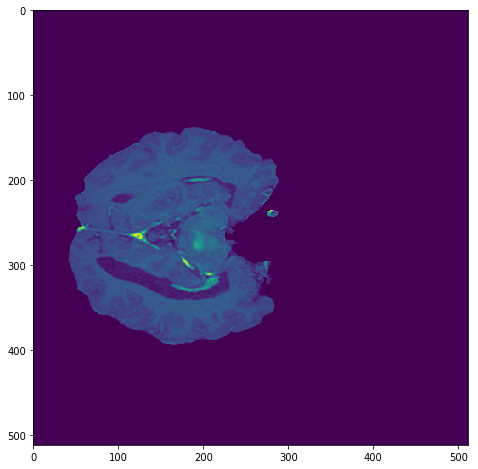

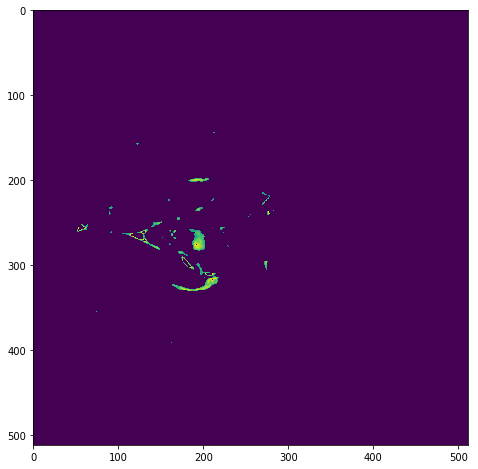

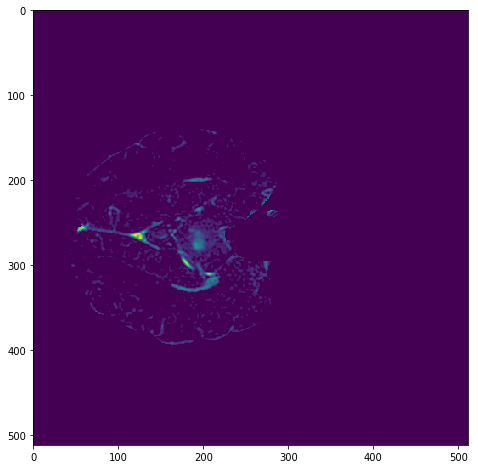

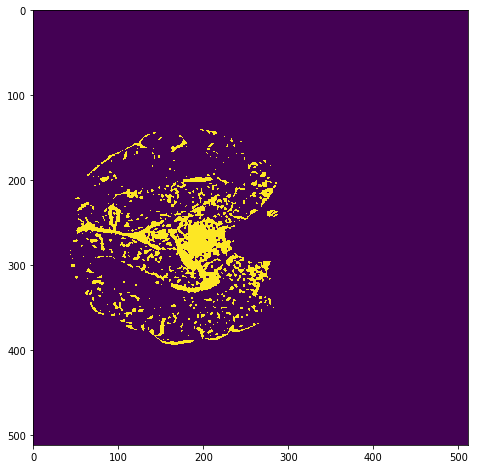

In [25]:
_idx = 0
plt.figure(figsize=(8,8))
plt.imshow(Y[...,_idx])
plt.figure(figsize=(8,8))
plt.imshow(x2[...,idx_kmeans[_idx]].squeeze())
plt.figure(figsize=(8,8))
plt.imshow(x2[...,idx_kmeans[_idx]].squeeze() * (Y[...,_idx]==5))

# it seems like it's simpler to threshold the difference image to get an enhancement mask
tmp = x2-x0
plt.figure(figsize=(8,8))
plt.imshow((tmp*(tmp > .05*np.max(abs(tmp))))[...,idx_kmeans[_idx]].squeeze())

plt.figure(figsize=(8,8))
plt.imshow(((tmp > .05*np.max(abs(tmp))))[...,idx_kmeans[_idx]].squeeze())

In [20]:
import SimpleITK as sitk
import subtle.subtle_preprocess as supre


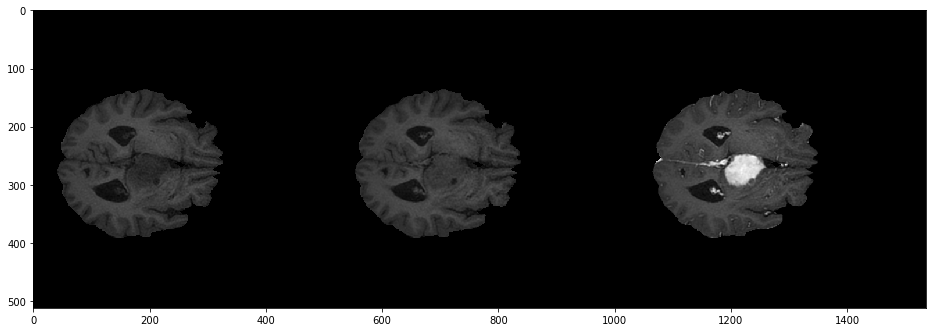

In [21]:
idx=150
plt.figure(figsize=(16,8))
suplot.imshowtile(np.stack((x0,x1,x2), axis=3)[:,:,idx,:].squeeze())

0.8827586206896552
0.993103448275862


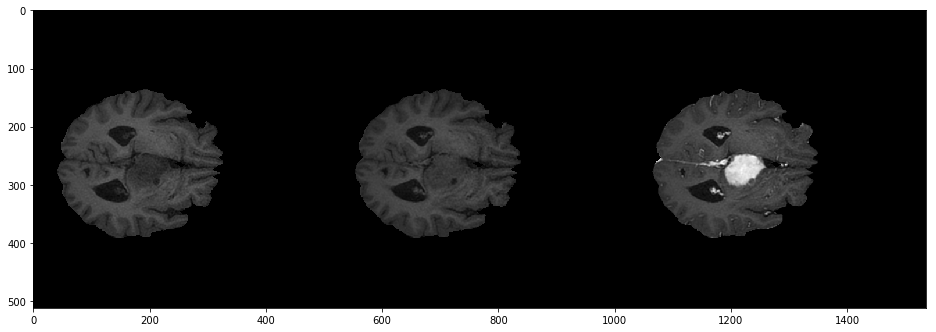

In [22]:
x2_sc = supre.scale_im_enhao(x0[...,idx-5:idx+5], x2[...,idx-5:idx+5])
print(x2_sc)
x2_scaled = x2 * x2_sc

x1_sc = supre.scale_im_enhao(x0[...,idx-5:idx+5], x1[...,idx-5:idx+5])
print(x1_sc)
x1_scaled = x1 * x2_sc

plt.figure(figsize=(16,8))
suplot.imshowtile(np.stack((x0,x1_scaled,x2_scaled), axis=3)[:,:,idx,:].squeeze())


image intensity normalization
scaling done, 3.4 s
image intensity normalization
scaling done, 3.46 s


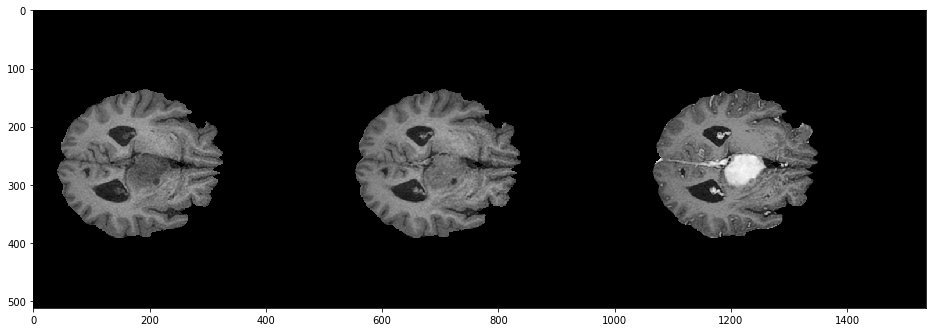

In [23]:
x2_hist_scaled = supre.scale_im(x0, x2_scaled)
x1_hist_scaled = supre.scale_im(x0, x1_scaled)
plt.figure(figsize=(16,8))
suplot.imshowtile(np.stack((x0,x1_hist_scaled,x2_hist_scaled), axis=3)[:,:,idx,:].squeeze())

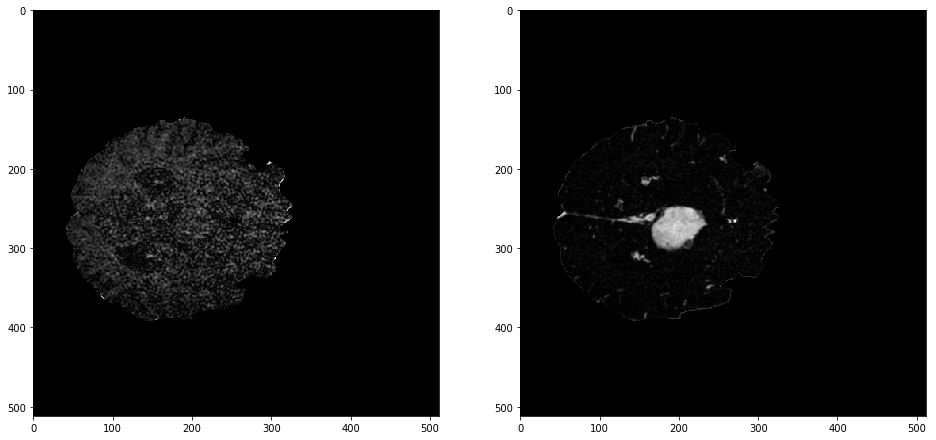

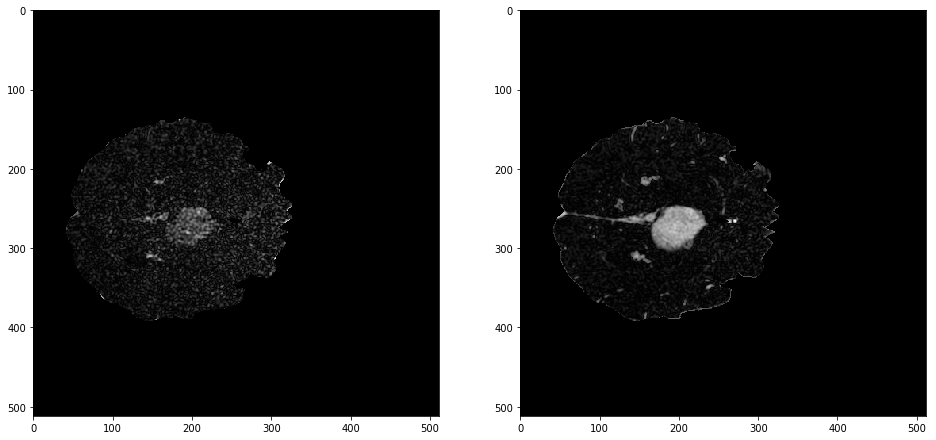

In [24]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(abs(x1_scaled[...,idx] - x0[...,idx]), cmap='gray')

plt.subplot(1,2,2)
plt.imshow(abs(x2_scaled[...,idx] - x0[...,idx]), cmap='gray')


plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(abs(x1_hist_scaled[...,idx] - x0[...,idx]), cmap='gray')

plt.subplot(1,2,2)
plt.imshow(abs(x2_hist_scaled[...,idx] - x0[...,idx]), cmap='gray')